In [36]:
import os
import time
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from IPython.display import clear_output

%matplotlib inline

In [61]:
video_dir = '/mnt/disks/datastorage/videos/'
weights_dir = '/mnt/disks/datastorage/weights/'
#file = 'v_Shooting_g11_v1_b.mov'
file = 'v_Shooting_g18_v1_c.MP4'
video_path = os.path.join(video_dir,'fens',file)
flownet_weights = os.path.join(weights_dir, 'FlowNet2-CSS.pth.tar')
spatial_weights = os.path.join('/home/mlp/two-stream-action-recognition/record/spatial', 'model_best_FENS.pth.tar')
motion_weights = os.path.join('/home/mlp/two-stream-action-recognition/record/motion', 'model_best_FENS.pth.tar')
flownet_model = 'FlowNet2CSS'
nb_classes = 4
skip_num = 1

In [62]:
!python pipeline.py --stream $video_path \
                    --nb_classes $nb_classes \
                    --model $flownet_model \
                    --optical_weights $flownet_weights \
                    --spatial_weights $spatial_weights \
                    --motion_weights $motion_weights

Parsing Arguments
  [0.005s] fp16: False
  [0.005s] fp16_scale: 1024.0
  [0.005s] image_size: [224, 224]
  [0.005s] images: []
  [0.005s] inference_size: [-1, -1]
  [0.005s] loss: L1Loss
  [0.005s] model: FlowNet2CSS
  [0.005s] model_batchNorm: False
  [0.006s] model_div_flow: 20.0
  [0.006s] motion_weights: /home/mlp/two-stream-action-recognition/record/motion/model_best_FENS.pth.tar
  [0.006s] nb_classes: 4
  [0.006s] number_gpus: 1
  [0.006s] optical_weights: /mnt/disks/datastorage/weights/FlowNet2-CSS.pth.tar
  [0.006s] rgb_max: 255.0
  [0.006s] seed: 1
  [0.006s] skip_frames: 1
  [0.006s] spatial_weights: /home/mlp/two-stream-action-recognition/record/spatial/model_best_FENS.pth.tar
  [0.006s] stream: /mnt/disks/datastorage/videos/fens/v_Shooting_g18_v1_c.MP4
  [0.006s] Operation finished

Building FlowNet2CSS model
/home/mlp/LENS/flownet2-pytorch/models.py:460: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  init.uniform(m.bias)
/home/mlp/LENS/flown

Processing frame 502
Processing frame 504
Processing frame 506
Processing frame 508
Processing frame 510
Processing frame 512
Processing frame 514
Processing frame 516
Processing frame 518
Processing frame 520
Processing frame 522
Processing frame 524
Processing frame 526
Processing frame 528
Processing frame 530
Processing frame 532
Processing frame 534
Processing frame 536
Processing frame 538
Processing frame 540
Processing frame 542
Processing frame 544
Processing frame 546
Processing frame 548
Processing frame 550
Processing frame 552
Processing frame 554
Processing frame 556
Processing frame 558
Processing frame 560
Processing frame 562
Processing frame 564
Processing frame 566
Processing frame 568
Processing frame 570
Processing frame 572
Processing frame 574
Processing frame 576
Processing frame 578
Processing frame 580
Processing frame 582
Processing frame 584
Processing frame 586
Processing frame 588
Processing frame 590
Processing frame 592
Processing frame 594
Processing fr

Processing frame 1270
Processing frame 1272
Processing frame 1274
Processing frame 1276
Processing frame 1278
Processing frame 1280
Processing frame 1282
Processing frame 1284
Processing frame 1286
Processing frame 1288
Processing frame 1290
Processing frame 1292
Processing frame 1294
Processing frame 1296
Processing frame 1298
Processing frame 1300
Processing frame 1302
Processing frame 1304
Processing frame 1306
Processing frame 1308
Processing frame 1310
Processing frame 1312
Processing frame 1314
Processing frame 1316
Processing frame 1318
Processing frame 1320
Processing frame 1322
Processing frame 1324
Processing frame 1326
Processing frame 1328
Processing frame 1330
Processing frame 1332
Processing frame 1334
Processing frame 1336
Processing frame 1338
Processing frame 1340
Processing frame 1342
Processing frame 1344
Processing frame 1346
Processing frame 1348
Processing frame 1350
Processing frame 1352
Processing frame 1354
Processing frame 1356
Processing frame 1358
Processing

In [65]:
# Load from file SVM
model_pickle_name = "/home/mlp/two-stream-action-recognition/fens_svm.pkl"
with open(model_pickle_name, 'rb') as file:
    svm_model = pickle.load(file)

In [91]:
video_dir = os.path.dirname(os.path.abspath(video_path))
video_name = os.path.splitext(os.path.basename(video_path))[0]
pickle_path = os.path.join(video_dir, '{}_predictions.pkl'.format(video_name))
use_svm = True

with open(pickle_path, 'rb') as pf:
    predictions = pickle.load(pf)
    predictions = np.array(predictions).squeeze()
    predictions_temporal = softmax(predictions[:, :nb_classes],1)
    predictions_spatial = softmax(predictions[:, nb_classes:(nb_classes*2)],1)
    pred_features = np.hstack((predictions_spatial,predictions_temporal))
    predictions_combined = predictions[:, (nb_classes*2):]
    if use_svm:
        actions_prob = svm_model.predict_proba(pred_features)
        actions = svm_model.predict(pred_features)-1
    else:
        actions = np.argmax(predictions_combined, axis=1) 

KeyboardInterrupt: 

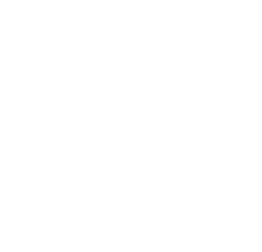

In [82]:
action_dict = {
    0: 'Theft',
    1: 'Assault',
    2: 'Shooting',
    3: 'No Action',
}

cap = cv2.VideoCapture(video_path)

frame_time = 0
frame_idx = 0
display = None
i = 0
while True:
    start_time = time.time()
    
    ret, frame = cap.read()
    if not ret:
        break
    
    try:
        label = action_dict[actions[frame_idx]]
    except IndexError:
        break
        
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.putText(
        frame,
        label,
        (10, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 255),
        thickness=3
    )
    
    if i < 0:
        frame_time += time.time() - start_time
        frame_idx += 1
        i+=1
        continue
        
        
    else:
        plt.axis('off')
        plt.imshow(frame)
        plt.show()
        clear_output(wait=True)

        frame_time += time.time() - start_time
        frame_idx += 1
cap.release()

frame_time /= frame_idx
print('Avg. frame processing time: {} s'.format(round(frame_time, 2)))